In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'sistla/datasets/grocery_dataset/1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']} #'val'
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']} #'val'
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

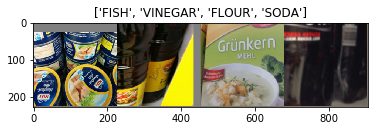

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
   def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\sindu/.torch\models\resnet50-19c8e357.pth
100.0%


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5756 Acc: 0.2625
val Loss: 1.2688 Acc: 0.6221
Epoch 1/24
----------
train Loss: 1.9642 Acc: 0.4304
val Loss: 1.0133 Acc: 0.6972
Epoch 2/24
----------
train Loss: 1.8127 Acc: 0.4677
val Loss: 0.8148 Acc: 0.7591
Epoch 3/24
----------
train Loss: 1.6730 Acc: 0.5148
val Loss: 0.7892 Acc: 0.7481
Epoch 4/24
----------
train Loss: 1.6681 Acc: 0.5078
val Loss: 0.8640 Acc: 0.7215
Epoch 5/24
----------
train Loss: 1.5910 Acc: 0.5233
val Loss: 0.7522 Acc: 0.7646
Epoch 6/24
----------
train Loss: 1.5510 Acc: 0.5421
val Loss: 0.7258 Acc: 0.7746
Epoch 7/24
----------
train Loss: 1.3551 Acc: 0.5943
val Loss: 0.6527 Acc: 0.8055
Epoch 8/24
----------
train Loss: 1.3556 Acc: 0.6042
val Loss: 0.6157 Acc: 0.8066
Epoch 9/24
----------
train Loss: 1.3851 Acc: 0.5892
val Loss: 0.6254 Acc: 0.8066
Epoch 10/24
----------
train Loss: 1.3395 Acc: 0.6118
val Loss: 0.6617 Acc: 0.7890
Epoch 11/24
----------
train Loss: 1.3517 Acc: 0.6038
val Loss: 0.6324 Acc: 0.7890
Epoch 12/24
--

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        
         if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

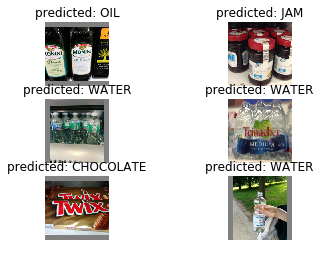

In [15]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [12]:
torch.save(model_ft, 'Resnet50.pt')
#model = torch.load('Resnet50.pt')
#model.parameters()